# Model Prediction Task I

## Exploratory Data Analysis (EDA)

In [24]:
import pandas as pd
import os

ROOT = os.path.abspath("..")

files = [
    os.path.join(ROOT, "Data", "HDB", "resale-flat-prices-based-on-approval-date-1990-1999.csv"),
    os.path.join(ROOT, "Data", "HDB", "resale-flat-prices-based-on-approval-date-2000-feb-2012.csv"),
    os.path.join(ROOT, "Data", "HDB", "resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv"),
    os.path.join(ROOT, "Data", "HDB", "resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv"),
    os.path.join(ROOT, "Data", "HDB", "resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv"),
]


# Check whether all files have the same columns
# Read columns of each file
columns_by_file = {
    f: set(pd.read_csv(f, nrows=0).columns)
    for f in files
}

# Reference: first file
ref_file = files[0]
ref_cols = columns_by_file[ref_file]

print(f'Reference file:\n{ref_file}')
print(f'Columns: {sorted(ref_cols)}\n')

for f, cols in columns_by_file.items():
    missing = ref_cols - cols
    extra = cols - ref_cols

    print('-' * 80)
    print(f'File: {f}')

    if not missing and not extra:
        print('Same columns as reference')
    else:
        if missing:
            print(f'Missing columns: {sorted(missing)}')
        if extra:
            print(f'Extra columns: {sorted(extra)}')

Reference file:
C:\Users\mh\Desktop\Project\Data\HDB\resale-flat-prices-based-on-approval-date-1990-1999.csv
Columns: ['block', 'flat_model', 'flat_type', 'floor_area_sqm', 'lease_commence_date', 'month', 'resale_price', 'storey_range', 'street_name', 'town']

--------------------------------------------------------------------------------
File: C:\Users\mh\Desktop\Project\Data\HDB\resale-flat-prices-based-on-approval-date-1990-1999.csv
Same columns as reference
--------------------------------------------------------------------------------
File: C:\Users\mh\Desktop\Project\Data\HDB\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv
Same columns as reference
--------------------------------------------------------------------------------
File: C:\Users\mh\Desktop\Project\Data\HDB\resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv
Same columns as reference
--------------------------------------------------------------------------------
File: C:\Users\m

## Notes after EDA and visual inspection of files:

For records prior to March 2012, the data are based on the date of approval for the resale transactions.
From March 2012 onwards, the data are based on the date of registration of the resale transactions.

From desktop research, the difference between date of approval and date of registration of resale transactions differ about 2 weeks apart. 
Since our data records this information by year and month, this gap can be ignored, and the dates can be treated as equivalent.

Column 'month' includes year_month (e.g. 2012-01) information.
Entries from Jan 2015 onwards include 'remaining_lease' information.

## Cleaning

In [25]:
# Column 'month' includes year_month information. 
# Rename this column to 'year_month' and split the information into two seperate columns, 'year' and 'month'

main_df = []

for f in files:
    df = pd.read_csv(f)

    if 'month' in df.columns:
        df = df.rename(columns={'month': 'year_month'})
        df[['year', 'month']] = (
            df['year_month']
            .astype(str)
            .str.split('-', expand=True)
            .astype(int)
        )

    main_df.append(df)

# Combine into a single DataFrame
main_df = pd.concat(main_df, ignore_index=True)


In [26]:
main_df.columns

Index(['year_month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'year', 'month', 'remaining_lease'],
      dtype='str')

In [27]:
# Look for unusual or unexpected values in categories (like town names or flat types)
# Make sure numbers fall within a reasonable range
# Check if any data is missing

# Columns by type
categorical = ['town', 'flat_type', 'storey_range', 'flat_model', 'year', 'month', 'year_month']

others = [
    'block', 'street_name',  # text
    'floor_area_sqm', 'resale_price', 'remaining_lease', 'lease_commence_date'  # numeric
]

print('=== CATEGORICAL ===')
for col in categorical:
    print(f'\n{col} ({main_df[col].nunique()} unique)')
    print(sorted(main_df[col].dropna().unique()))

print('\n=== OTHERS ===')
for col in others:
    s = main_df[col].dropna()
    n_unique = s.nunique()
    n_missing = main_df[col].isna().sum()

    if s.dtype == object or n_unique > 50:  # text
        sample = s.unique()[:20]
        print(f'\n{col} ({n_unique} unique, missing={n_missing})')
        print(f'Sample: {sample}')
    else:  # numeric / small categorical / time-like
        print(f'\n{col} ({n_unique} unique, missing={n_missing})')
        print(f'Range: min={s.min()}, max={s.max()}')


=== CATEGORICAL ===

town (27 unique)
['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'LIM CHU KANG', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN']

flat_type (8 unique)
['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI GENERATION', 'MULTI-GENERATION']

storey_range (25 unique)
['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12', '11 TO 15', '13 TO 15', '16 TO 18', '16 TO 20', '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30', '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40', '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']

flat_model (33 unique)
['2-ROOM', '2-room', 'APARTMENT', 'Adjoined flat', 'Apartment', 'DBSS', 'IMPROVED', 'IMPROVED-MAISONETTE', 'Improved

In [28]:
# Standardise columns
main_df['flat_type'] = main_df['flat_type'].str.lower().replace('multi generation', 'multi-generation')
main_df['flat_model'] = main_df['flat_model'].str.upper()  # normalise casing

## Independent Variables Data Preprocessing - Variable creation

In [29]:
# Hypothesis: price of apartments affected by the town or flat type or flat model of the apartments
# Categorical variables: 'town' 'flat_type' and 'flat_model'
# Create dummy variables for each category. These dummy variables are set to 1 when an observation belongs to a specific category and 0 otherwise.
categorical_cols = ['town', 'flat_type', 'flat_model']
for col in categorical_cols:
    dummies = pd.get_dummies(main_df[col], prefix=col)
    main_df = pd.concat([main_df, dummies], axis=1)

In [30]:
# Hypothesis: price of apartments tends to be higher(lower) if they are located on a higher(lower) floor. 
# Change floor level ranges into a single (median) floor number (e.g. a storey_range value of “10 TO 12” would be modified to 11)
# Dummies were not created as dummy variables ignore ordering (model will see them as independent categories, ignoring that 11 is higher than 3)
def storey_median(x):
    # split 'XX TO YY', convert to integar, take median
    try:
        start, end = map(int, x.split(' TO '))
        return int((start + end) / 2)
    except:
        return np.nan

main_df['storey_range_median'] = main_df['storey_range'].apply(storey_median)

In [31]:
# Hypothesis: price of apartments tends to be higher(lower) if they have longer(shorter) remaining lease.

# Observation from EDA:
# From January 2015 onwards, the dataset records remaining lease information.
# Earlier records do not include this.

# Extract remaining lease (in years) from records where it is available.
# Example: '94 years 6 months' -> 94
main_df['remaining_lease_years'] = (
    main_df['remaining_lease']
    .str.extract(r'(\d+)')
    .astype(float)
)

# Compute remaining lease using the formula: 
# remaining lease = 99 years − (date of approval or registration for the resale transaction  − lease start year)
main_df['remaining_lease_calc'] = 99 - (main_df['year'] - main_df['lease_commence_date'])

# Check whether the entries with remaining lease information is consistent with the formula.
# A tolerance of ±1 year is allowed to account for differences caused by months.
main_df['remaining_lease_check'] = (
    (main_df['remaining_lease_years'] - main_df['remaining_lease_calc']).abs() <= 1
)

# For older records without remaining lease information,
# fill in the missing values using the calculated remaining lease.
main_df['remaining_lease_years'] = main_df['remaining_lease_years'].fillna(
    main_df['remaining_lease_calc']
)

main_df

,year_month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2,storey_range_median,remaining_lease_years,remaining_lease_calc,remaining_lease_check
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,...,False,False,False,False,False,False,11,86.0,86,False
1,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,5,86.0,86,False
2,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,...,False,False,False,False,False,False,11,86.0,86,False
3,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,8,86.0,86,False
4,1990-01,ANG MO KIO,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,...,False,False,False,False,False,False,5,85.0,85,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09,YISHUN,5 room,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,...,False,False,False,False,False,False,8,66.0,66,True
826577,2020-09,YISHUN,5 room,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,...,False,False,False,False,False,False,8,65.0,66,True
826578,2020-09,YISHUN,5 room,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,...,False,False,False,False,False,False,5,66.0,66,True
826579,2020-09,YISHUN,executive,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,...,False,False,False,False,False,False,5,66.0,66,True


In [32]:
main_df.columns

Index(['year_month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'year', 'month', 'remaining_lease', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_LIM CHU KANG', 'town_MARINE PARADE', 'town_PASIR RIS',
       'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG',
       'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS',
       'town_YISHUN', 'flat_type_1 room', 'flat_type_2 room',
       'flat_type_3 room', 'flat_type_4 room', 'flat_type_5 room',
       'flat_type_executive', 'flat_type_multi-generation',
       'flat_model_2-ROOM', 'flat_model_ADJOINED FLAT', 'flat_model_APA

In [33]:
# Drop columns that are no longer needed
main_df = main_df.drop(columns=['remaining_lease', 'remaining_lease_calc', 'remaining_lease_check'])
main_df

,year_month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,flat_model_PREMIUM APARTMENT,flat_model_PREMIUM APARTMENT LOFT,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2,storey_range_median,remaining_lease_years
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,...,False,False,False,False,False,False,False,False,11,86.0
1,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,False,False,5,86.0
2,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,...,False,False,False,False,False,False,False,False,11,86.0
3,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,False,False,8,86.0
4,1990-01,ANG MO KIO,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,...,False,False,False,False,False,False,False,False,5,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09,YISHUN,5 room,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,...,False,False,False,False,False,False,False,False,8,66.0
826577,2020-09,YISHUN,5 room,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,...,False,False,False,False,False,False,False,False,8,65.0
826578,2020-09,YISHUN,5 room,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,...,False,False,False,False,False,False,False,False,5,66.0
826579,2020-09,YISHUN,executive,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,...,False,False,False,False,False,False,False,False,5,66.0


In [34]:
main_df.columns

Index(['year_month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'year', 'month', 'town_ANG MO KIO', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_LIM CHU KANG', 'town_MARINE PARADE', 'town_PASIR RIS',
       'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG',
       'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS',
       'town_YISHUN', 'flat_type_1 room', 'flat_type_2 room',
       'flat_type_3 room', 'flat_type_4 room', 'flat_type_5 room',
       'flat_type_executive', 'flat_type_multi-generation',
       'flat_model_2-ROOM', 'flat_model_ADJOINED FLAT', 'flat_model_APARTMENT',
       'fl

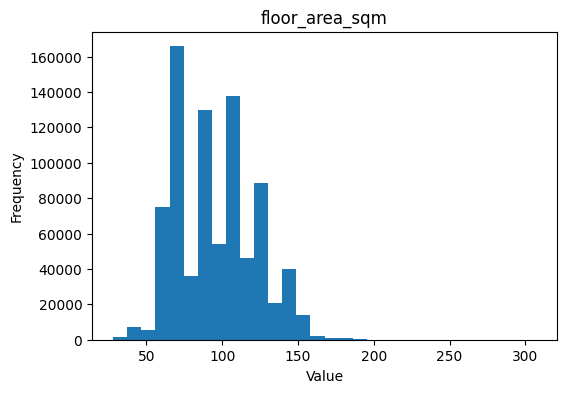

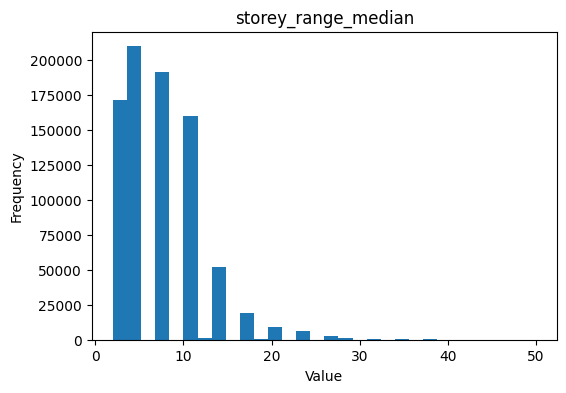

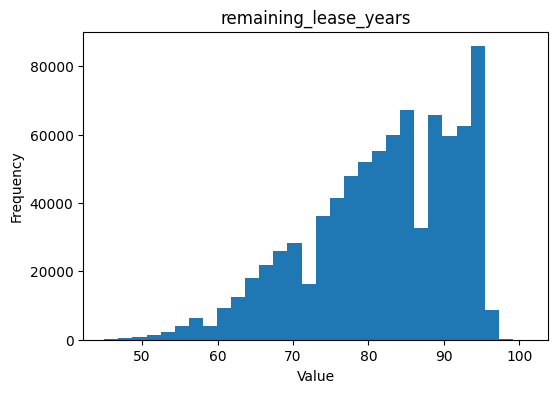

In [35]:
# Visualise distribution of features
import matplotlib.pyplot as plt

numeric_cols = ['floor_area_sqm', 'storey_range_median', 'remaining_lease_years']
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(main_df[col].dropna(), bins=30)
    plt.title(f'{col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

floor_area_sqm          -3.565002e-16
storey_range_median     -1.056297e-16
remaining_lease_years    2.816792e-16
dtype: float64
floor_area_sqm           1.000001
storey_range_median      1.000001
remaining_lease_years    1.000001
dtype: float64


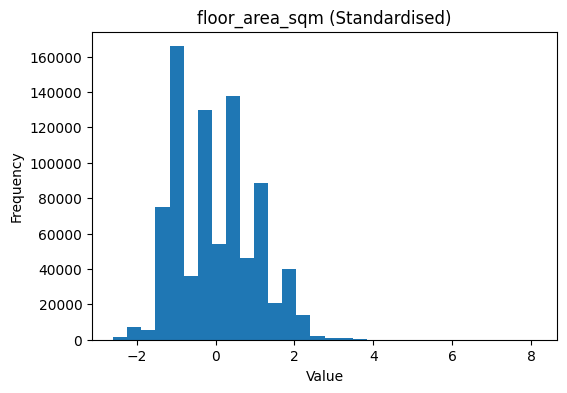

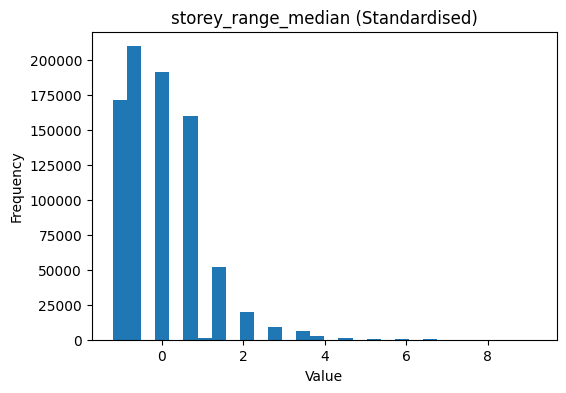

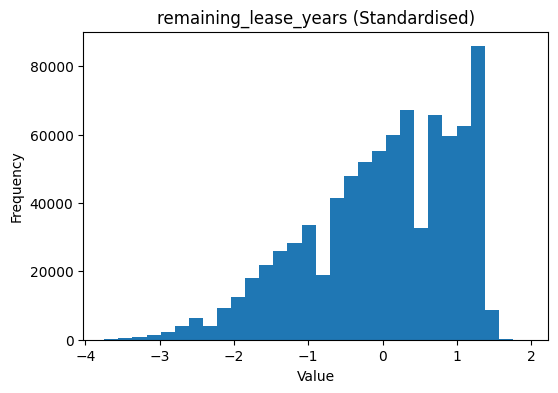

In [36]:
# Standardise numeric features 
# Standardisation put all features on the same scale. 
# This means each feature is centered around zero and has a similar spread. 
# Standardisation helps models work properly and ensures fair comparisons between different models. 

from sklearn.preprocessing import StandardScaler

numeric_cols = ['floor_area_sqm', 'storey_range_median', 'remaining_lease_years']  # only numeric

scaler = StandardScaler()
main_df[numeric_cols] = scaler.fit_transform(main_df[numeric_cols])

# Check means and std
print(main_df[numeric_cols].mean())  # should be 0
print(main_df[numeric_cols].std())   # should be 1

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(main_df[col].dropna(), bins=30)
    plt.title(f'{col} (Standardised)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

## Dependent Variable preprocessing

In [37]:
main_df

,year_month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,flat_model_PREMIUM APARTMENT,flat_model_PREMIUM APARTMENT LOFT,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2,storey_range_median,remaining_lease_years
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,-2.477558,IMPROVED,1977,9000.0,...,False,False,False,False,False,False,False,False,0.747728,0.419412
1,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,04 TO 06,-2.477558,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,False,False,-0.550343,0.419412
2,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,-2.477558,IMPROVED,1977,8000.0,...,False,False,False,False,False,False,False,False,0.747728,0.419412
3,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,07 TO 09,-2.477558,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,False,False,0.098692,0.419412
4,1990-01,ANG MO KIO,3 room,216,ANG MO KIO AVE 1,04 TO 06,-0.865711,NEW GENERATION,1976,47200.0,...,False,False,False,False,False,False,False,False,-0.550343,0.317855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09,YISHUN,5 room,716,YISHUN ST 71,07 TO 09,1.360171,IMPROVED,1987,440000.0,...,False,False,False,False,False,False,False,False,0.098692,-1.611714
826577,2020-09,YISHUN,5 room,760,YISHUN ST 72,07 TO 09,1.014776,IMPROVED,1987,458000.0,...,False,False,False,False,False,False,False,False,0.098692,-1.713270
826578,2020-09,YISHUN,5 room,835,YISHUN ST 81,04 TO 06,1.014776,IMPROVED,1987,490000.0,...,False,False,False,False,False,False,False,False,-0.550343,-1.611714
826579,2020-09,YISHUN,executive,791,YISHUN AVE 2,04 TO 06,1.935831,MAISONETTE,1987,558000.0,...,False,False,False,False,False,False,False,False,-0.550343,-1.611714


In [39]:
# Dependent variable (Resale price) like to be affected by inflation
# Adjust for inflation by using a price index. 
'''
HDB has a resale price index (RPI) can be used to compare the overall price movements of HDB resale flats. 
It is calculated using resale transactions registered across towns, flat types, and models. The base period is the 1st quarter of 2009, i.e. RPI has a value of 100 in 1st Quarter 2009. For example, if the index increases from 100 to 108 in 1 year, that means that on the whole, HDB resale flat prices increased by about 8% over that year.

Dividing the resale price by the RPI converts the nominal price (influenced by inflation) into a real price, 
expressed in constant base-year dollars (Q1 2009) where the index is 100.
For example, if a flat sold for $400,000 when the RPI was 108 (meaning prices had risen 8% overall since 2009), 
dividing $400,000 by 108/100 gives about $370,370 in 2009-equivalent value.
'''

# Read RPI table
rpi_df = pd.read_csv(os.path.join(ROOT, "Data", "HDB", "4Q2025 RPI Table.csv"))

# Map RPI quarters in RPI table to Q1–Q4
quarter_map = {'I':'Q1','II':'Q2','III':'Q3','IV':'Q4'}
rpi_df['quarter'] = rpi_df['Quarter'].map(quarter_map)
rpi_df['year_quarter'] = rpi_df['Year'].astype(str) + '-' + rpi_df['quarter']

# Map months to quarters in main_df
def month_to_quarter(month):
    month = int(month)
    if month in [1,2,3]:
        return 'Q1'
    elif month in [4,5,6]:
        return 'Q2'
    elif month in [7,8,9]:
        return 'Q3'
    else:
        return 'Q4'

main_df['quarter'] = main_df['month'].astype(int).apply(month_to_quarter)
main_df['year_quarter'] = main_df['year'].astype(str) + '-' + main_df['quarter']

# Merge RPI table into main_df
main_df = main_df.merge(rpi_df[['year_quarter','Index']], on='year_quarter', how='left')
main_df.rename(columns={'Index':'RPI'}, inplace=True)

# Adjust resale price for inflation using 2009-Q1 as base
base_rpi = rpi_df.loc[rpi_df['year_quarter'] == '2009-Q1', 'Index'].values[0]
main_df['resale_price_adj'] = main_df['resale_price'] * (base_rpi / main_df['RPI'])

# Round for readability
main_df['resale_price'] = main_df['resale_price'].round(0)
main_df['resale_price_adj'] = main_df['resale_price_adj'].round(0)

# Drop helper columns
main_df.drop(columns=['quarter','year_quarter'], inplace=True)

main_df

,year_month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2,storey_range_median,remaining_lease_years,RPI,resale_price_adj
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,-2.477558,IMPROVED,1977,9000.0,...,False,False,False,False,False,False,0.747728,0.419412,24.3,37037.0
1,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,04 TO 06,-2.477558,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,-0.550343,0.419412,24.3,24691.0
2,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,-2.477558,IMPROVED,1977,8000.0,...,False,False,False,False,False,False,0.747728,0.419412,24.3,32922.0
3,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,07 TO 09,-2.477558,IMPROVED,1977,6000.0,...,False,False,False,False,False,False,0.098692,0.419412,24.3,24691.0
4,1990-01,ANG MO KIO,3 room,216,ANG MO KIO AVE 1,04 TO 06,-0.865711,NEW GENERATION,1976,47200.0,...,False,False,False,False,False,False,-0.550343,0.317855,24.3,194239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09,YISHUN,5 room,716,YISHUN ST 71,07 TO 09,1.360171,IMPROVED,1987,440000.0,...,False,False,False,False,False,False,0.098692,-1.611714,133.9,328603.0
826577,2020-09,YISHUN,5 room,760,YISHUN ST 72,07 TO 09,1.014776,IMPROVED,1987,458000.0,...,False,False,False,False,False,False,0.098692,-1.713270,133.9,342046.0
826578,2020-09,YISHUN,5 room,835,YISHUN ST 81,04 TO 06,1.014776,IMPROVED,1987,490000.0,...,False,False,False,False,False,False,-0.550343,-1.611714,133.9,365945.0
826579,2020-09,YISHUN,executive,791,YISHUN AVE 2,04 TO 06,1.935831,MAISONETTE,1987,558000.0,...,False,False,False,False,False,False,-0.550343,-1.611714,133.9,416729.0


In [40]:
main_df.columns

Index(['year_month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'year', 'month', 'town_ANG MO KIO', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_LIM CHU KANG', 'town_MARINE PARADE', 'town_PASIR RIS',
       'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG',
       'town_SERANGOON', 'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS',
       'town_YISHUN', 'flat_type_1 room', 'flat_type_2 room',
       'flat_type_3 room', 'flat_type_4 room', 'flat_type_5 room',
       'flat_type_executive', 'flat_type_multi-generation',
       'flat_model_2-ROOM', 'flat_model_ADJOINED FLAT', 'flat_model_APARTMENT',
       'fl

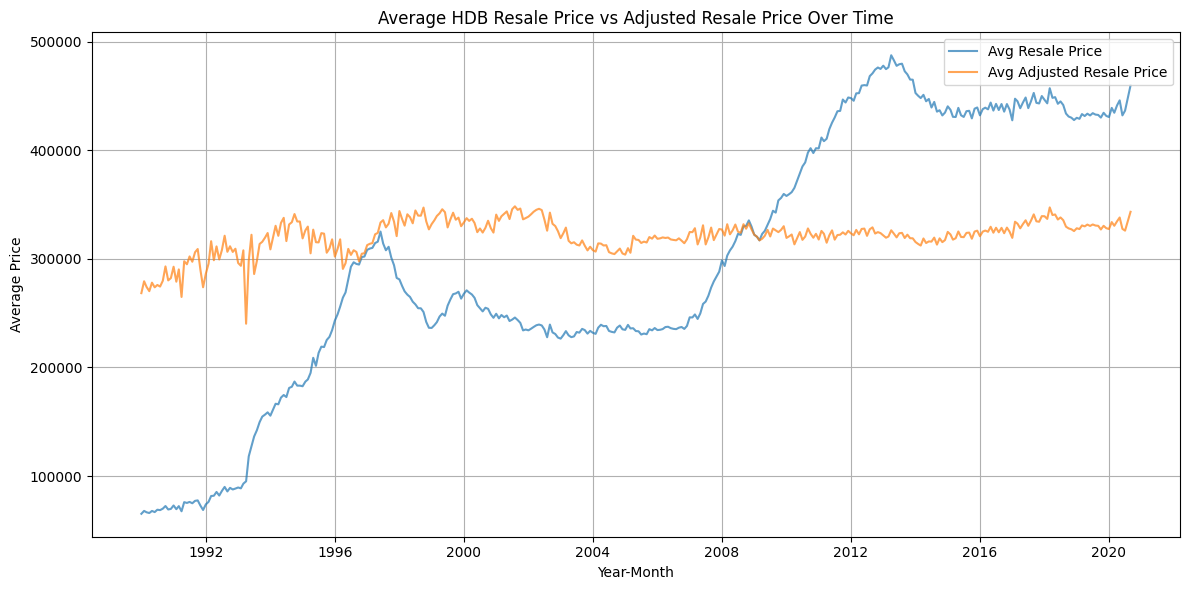

In [41]:
# Visualise the average resale price and the average adjusted resale price
import matplotlib.pyplot as plt

# Convert 'year_month' to datetime
main_df['year_month'] = pd.to_datetime(main_df['year_month'], format='%Y-%m')

# Group by month and take mean
avg_prices = main_df.groupby('year_month')[['resale_price', 'resale_price_adj']].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_prices.index, avg_prices['resale_price'], label='Avg Resale Price', alpha=0.7)
plt.plot(avg_prices.index, avg_prices['resale_price_adj'], label='Avg Adjusted Resale Price', alpha=0.7)

plt.xlabel('Year-Month')
plt.ylabel('Average Price')
plt.title('Average HDB Resale Price vs Adjusted Resale Price Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


From the graph above, the inflation effects have been removed as the average adjusted resale price remain relatively constant throughout the years.

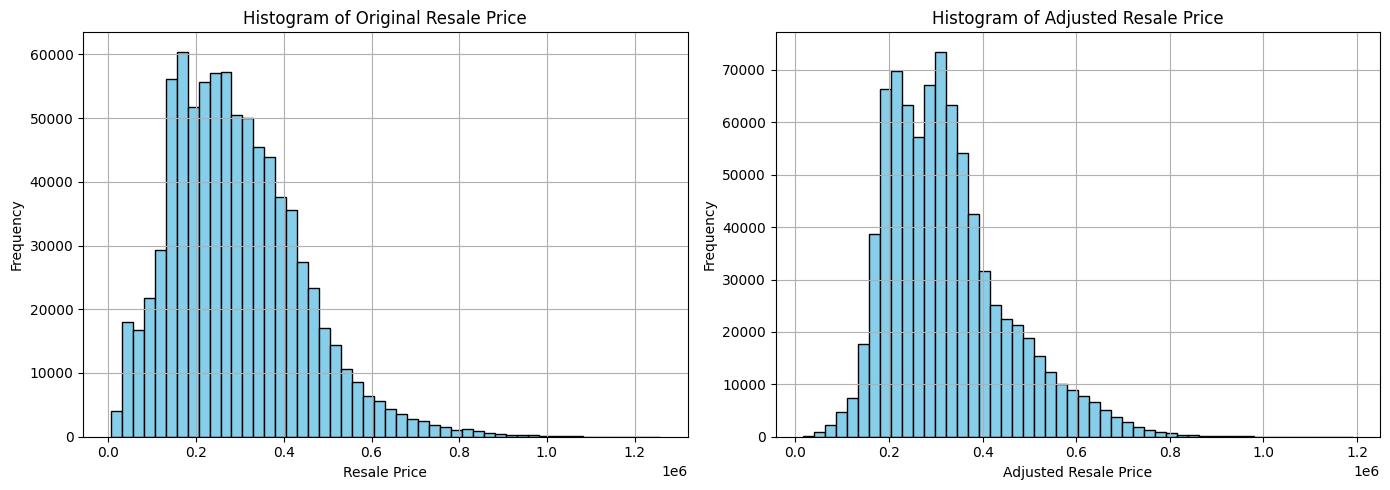

In [42]:
# Histograms
plt.figure(figsize=(14,5))

# Left: Histogram of original resale prices
plt.subplot(1,2,1)
plt.hist(main_df['resale_price'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Original Resale Price')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
plt.grid(True)

# Right: Histogram of adjusted resale prices
plt.subplot(1,2,2)
plt.hist(main_df['resale_price_adj'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Adjusted Resale Price')
plt.xlabel('Adjusted Resale Price')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


In [43]:
list(main_df.columns)

['year_month',
 'town',
 'flat_type',
 'block',
 'street_name',
 'storey_range',
 'floor_area_sqm',
 'flat_model',
 'lease_commence_date',
 'resale_price',
 'year',
 'month',
 'town_ANG MO KIO',
 'town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_LIM CHU KANG',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'flat_type_1 room',
 'flat_type_2 room',
 'flat_type_3 room',
 'flat_type_4 room',
 'flat_type_5 room',
 'flat_type_executive',
 'flat_type_multi-generation',
 'flat_model_2-ROOM',
 'flat_model_ADJOINED FLAT',
 'flat_model_APARTMENT',
 'flat_model_DBSS',
 'flat_model_IMPROVED',
 'flat_model_IM

## Train-test split

In [44]:
from sklearn.model_selection import train_test_split

# Set the dependent variable (what is to be predicted)
y = main_df['resale_price_adj'] 

# Prepare the independent variables (X) by dropping columns that are not useful or redundant
X = main_df.drop(columns=[
    'year_month',       # Already split into year and month
    'town',             # Original categorical; already encoded as dummies
    'flat_type',        # Original categorical; already encoded as dummies
    'block',            # Likely irrelevant for prediction
    'street_name',      # Likely irrelevant for prediction
    'storey_range',     # Already transformed and standardised
    'flat_model',       # Original categorical; already encoded as dummies
    'resale_price',     # Unadjusted version of dependent variable
    'resale_price_adj', # Dependent variable
    'RPI'               # Likely irrelevant for prediction
])

In [45]:
y

0          37037.0
1          24691.0
2          32922.0
3          24691.0
4         194239.0
            ...   
826576    328603.0
826577    342046.0
826578    365945.0
826579    416729.0
826580    414488.0
Name: resale_price_adj, Length: 826581, dtype: float64

In [46]:
X

,floor_area_sqm,lease_commence_date,year,month,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,...,flat_model_PREMIUM APARTMENT,flat_model_PREMIUM APARTMENT LOFT,flat_model_PREMIUM MAISONETTE,flat_model_SIMPLIFIED,flat_model_STANDARD,flat_model_TERRACE,flat_model_TYPE S1,flat_model_TYPE S2,storey_range_median,remaining_lease_years
0,-2.477558,1977,1990,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.747728,0.419412
1,-2.477558,1977,1990,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.550343,0.419412
2,-2.477558,1977,1990,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.747728,0.419412
3,-2.477558,1977,1990,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.098692,0.419412
4,-0.865711,1976,1990,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.550343,0.317855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,1.360171,1987,2020,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.098692,-1.611714
826577,1.014776,1987,2020,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.098692,-1.713270
826578,1.014776,1987,2020,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.550343,-1.611714
826579,1.935831,1987,2020,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.550343,-1.611714


In [47]:
# Split the dataset into training and testing sets
# X_train, y_train: data used to train the model
# X_test, y_test: data used to evaluate model performance
# test_size=0.3 -> 30% of data reserved for testing, 70% for training
# This ensures the model is trained on one portion of the data and tested on unseen data to check its predictive performance.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

# Predictive models

## Baseline model - Linear regression

In [48]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Reference: https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

#Model
lr = LinearRegression()

#Fit model
lr.fit(X_train, y_train)

#predict
prediction = lr.predict(X_test)

#actual
actual = y_test

train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print('The train score for lr model is {}'.format(train_score_lr))
print('The test score for lr model is {}'.format(test_score_lr))

The train score for lr model is 0.8369269428787808
The test score for lr model is 0.8373342689889502


In [49]:
# Linear Regression coefficients
lr_coefs = pd.Series(lr.coef_, index=X_train.columns)

print("\nLinear Regression: Features sorted by largest positive effect on adjusted resale price")
lr_coefs_sorted_positive = lr_coefs.sort_values(ascending=False)
print(lr_coefs_sorted_positive.head(10))  # top 10 positive

print("\nLinear Regression: Features sorted by largest negative effect on adjusted resale price")
lr_coefs_sorted_negative = lr_coefs.sort_values(ascending=True)
print(lr_coefs_sorted_negative.head(10))  # top 10 negative



Linear Regression: Features sorted by largest positive effect on adjusted resale price
flat_model_TERRACE                   148925.670131
flat_model_TYPE S2                   118172.807926
flat_model_TYPE S1                   116857.249002
town_MARINE PARADE                   115694.157700
town_BUKIT TIMAH                      97664.760846
flat_type_5 room                      78784.422486
flat_model_PREMIUM APARTMENT LOFT     78034.582875
town_BISHAN                           76940.537365
town_BUKIT MERAH                      72722.200135
flat_type_executive                   71875.619813
dtype: float64

Linear Regression: Features sorted by largest negative effect on adjusted resale price
flat_type_1 room           -118021.915239
town_SEMBAWANG              -94575.607558
town_LIM CHU KANG           -90530.852797
flat_model_ADJOINED FLAT    -89716.706641
flat_model_SIMPLIFIED       -81365.600230
flat_model_STANDARD         -78719.379735
town_WOODLANDS              -77588.917778
flat_

<Axes: >

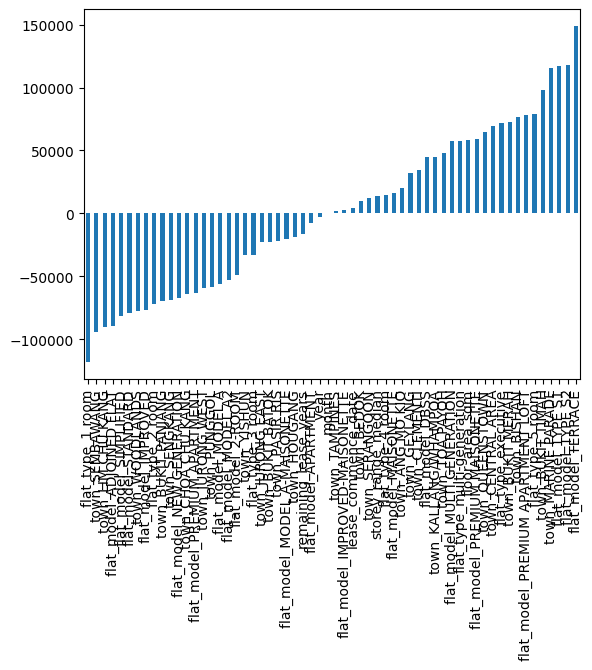

In [50]:
# Visualise Linear Regression coefficients
pd.Series(lr.coef_, X_train.columns).sort_values(ascending = True).plot(kind = "bar")

# Ridge and lasso regression

## Select the best penalty value (alpha) for ridge and lasso

In [51]:
import warnings
import numpy as np

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

from sklearn.linear_model import RidgeCV, LassoCV 

# Candidate alpha values 
alphas = [0.01, 0.1, 1, 10, 50, 100] 

# Ridge Regression with 10-fold CV 
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring='r2') 
ridge_cv.fit(X_train, y_train) 
print(f"Best alpha for Ridge: {ridge_cv.alpha_:.3f}") 
print(f"Ridge CV score: {ridge_cv.best_score_:.3f}" if hasattr(ridge_cv, 'best_score_') else "CV complete") 

# Lasso Regression with 10-fold CV 
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42) 
lasso_cv.fit(X_train, y_train) 
print(f"Best alpha for Lasso: {lasso_cv.alpha_:.3f}") 
print(f"Lasso CV score (R^2 on train): {lasso_cv.score(X_train, y_train):.3f}")

Best alpha for Ridge: 1.000
Ridge CV score: 0.837
Best alpha for Lasso: 0.010
Lasso CV score (R^2 on train): 0.837


In [52]:
# From above, best alpha for ridge is 1
# Ridge Regression Model
ridgeReg = Ridge(alpha=1)

ridgeReg.fit(X_train,y_train)

#train and test score for ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print('The train score for ridge model is {}'.format(train_score_ridge))
print('The test score for ridge model is {}'.format(test_score_ridge))

The train score for ridge model is 0.8369268403466419
The test score for ridge model is 0.8373335582879633


In [53]:
# Ridge Regression coefficients
ridge_coefs = pd.Series(ridgeReg.coef_, index=X_train.columns)

print("\nRidge Regression: Features sorted largest positive effect on adjusted resale price")
ridge_coefs_sorted_positive = ridge_coefs.sort_values(ascending=False)
print(ridge_coefs_sorted_positive.head(10))  # top 10

print("\nRidge Regression: Features sorted largest negative effect on adjusted resale price")
ridge_coefs_sorted_negative = ridge_coefs.sort_values(ascending=True)
print(ridge_coefs_sorted_negative.head(10))


Ridge Regression: Features sorted largest positive effect on adjusted resale price
flat_model_TERRACE                   148812.384707
flat_model_TYPE S2                   117185.345809
flat_model_TYPE S1                   116501.730366
town_MARINE PARADE                   115602.146503
town_BUKIT TIMAH                      97532.784647
flat_type_5 room                      78688.981319
town_BISHAN                           76863.934813
flat_model_PREMIUM APARTMENT LOFT     74367.956751
town_BUKIT MERAH                      72645.158654
flat_type_executive                   71741.194734
dtype: float64

Ridge Regression: Features sorted largest negative effect on adjusted resale price
flat_type_1 room           -117800.469325
town_SEMBAWANG              -94623.923041
flat_model_ADJOINED FLAT    -89314.290395
town_LIM CHU KANG           -88738.973765
flat_model_SIMPLIFIED       -81044.860902
flat_model_STANDARD         -78390.201393
town_WOODLANDS              -77659.557348
flat_model_IM

<Axes: >

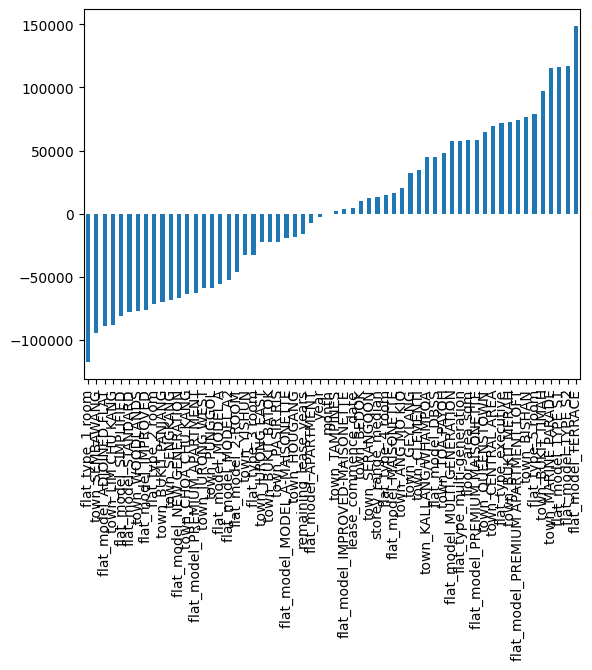

In [54]:
# Visualise Ridge Regression coefficients
pd.Series(ridge_coefs, X_train.columns).sort_values(ascending = True).plot(kind = "bar")

In [55]:
# Lasso regression model
# From above, best alpha for lasso is 0.01
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

The train score for ls model is 0.8369237147096672
The test score for ls model is 0.8373303279697181


In [56]:
# Lasso coefficients
lasso_coefs = pd.Series(lasso.coef_, index=X_train.columns)

print("\nLasso Regression: Features sorted by largest positive effect on adjusted resale price")
lasso_coefs_sorted_positive = lasso_coefs.sort_values(ascending=False)
print(lasso_coefs_sorted_positive.head(10))  # top 10 positive

print("\nLasso Regression: Features sorted by largest negative effect on adjusted resale price")
lasso_coefs_sorted_negative = lasso_coefs.sort_values(ascending=True)
print(lasso_coefs_sorted_negative.head(10))  # top 10 negative


Lasso Regression: Features sorted by largest positive effect on adjusted resale price
flat_model_TERRACE                   213293.588177
flat_model_TYPE S2                   182985.870974
flat_model_TYPE S1                   181584.873887
flat_model_PREMIUM APARTMENT LOFT    142503.737532
town_MARINE PARADE                   133165.802098
flat_model_PREMIUM MAISONETTE        123566.062427
flat_type_multi-generation           122172.526498
town_BUKIT TIMAH                     115113.714784
flat_model_DBSS                      109466.931122
town_BISHAN                           94388.440015
dtype: float64

Lasso Regression: Features sorted by largest negative effect on adjusted resale price
flat_type_1 room     -170458.235292
flat_type_2 room     -124218.294045
flat_type_3 room      -85377.237112
town_SEMBAWANG        -77140.813813
town_LIM CHU KANG     -72880.246053
town_WOODLANDS        -60155.537537
town_BUKIT PANJANG    -52416.825041
town_SENGKANG         -51264.913068
town_CHOA CHU

<Axes: >

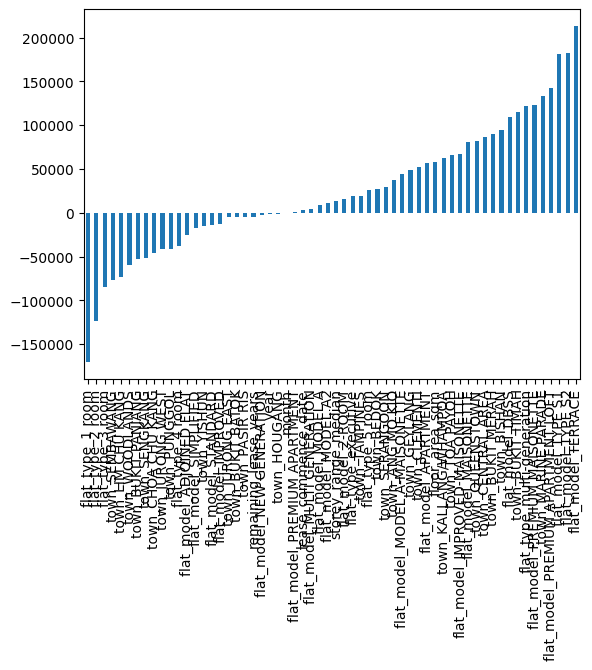

In [57]:
# Visualise Lasso coefficients
pd.Series(lasso.coef_, X_train.columns).sort_values(ascending = True).plot(kind = "bar")

## Decision Tree

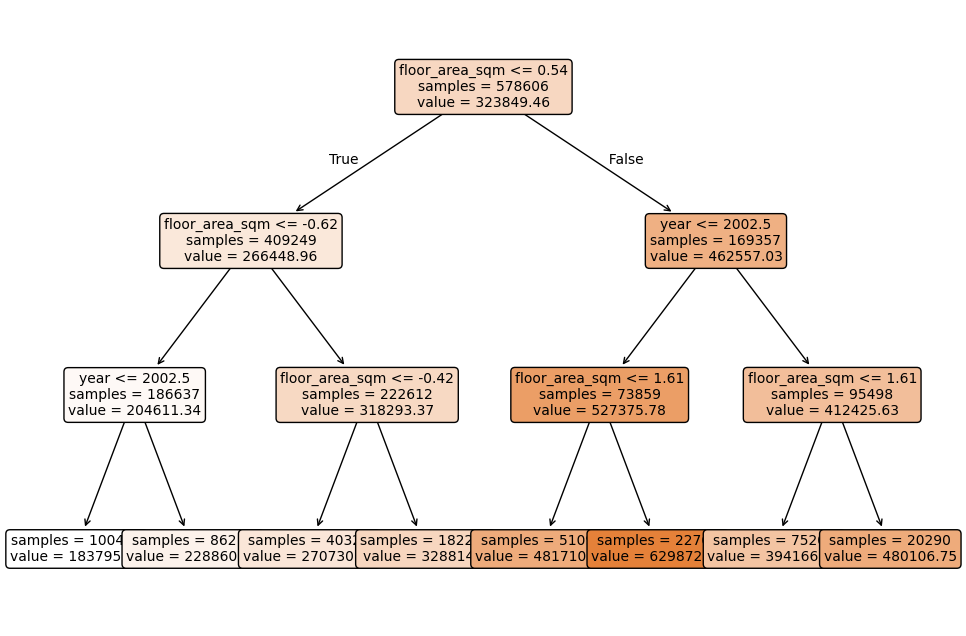

In [58]:
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_text

# Initialize Decision Tree Regressor
dtree = DecisionTreeRegressor(max_depth=3, random_state=42)  # based on visual inspection, max depth of 3 is cleanest without too much infomation.

# Fit Decision Tree
dtree.fit(X_train, y_train)

plt.figure(figsize=(12,8))
plot_tree(
dtree,
feature_names=X_train.columns,
filled=True,
rounded=True,
fontsize=10,
impurity=False,
precision=2
)
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
text_tree = export_text(dtree, feature_names=X_train.columns.tolist())
print(text_tree)

|--- floor_area_sqm <= 0.54
|   |--- floor_area_sqm <= -0.62
|   |   |--- year <= 2002.50
|   |   |   |--- value: [183795.07]
|   |   |--- year >  2002.50
|   |   |   |--- value: [228860.46]
|   |--- floor_area_sqm >  -0.62
|   |   |--- floor_area_sqm <= -0.42
|   |   |   |--- value: [270730.36]
|   |   |--- floor_area_sqm >  -0.42
|   |   |   |--- value: [328814.80]
|--- floor_area_sqm >  0.54
|   |--- year <= 2002.50
|   |   |--- floor_area_sqm <= 1.61
|   |   |   |--- value: [481710.93]
|   |   |--- floor_area_sqm >  1.61
|   |   |   |--- value: [629872.95]
|   |--- year >  2002.50
|   |   |--- floor_area_sqm <= 1.61
|   |   |   |--- value: [394166.27]
|   |   |--- floor_area_sqm >  1.61
|   |   |   |--- value: [480106.75]




Top features driving price changes:
floor_area_sqm         0.909711
year                   0.090289
lease_commence_date    0.000000
month                  0.000000
town_ANG MO KIO        0.000000
town_BEDOK             0.000000
town_BISHAN            0.000000
town_BUKIT BATOK       0.000000
town_BUKIT MERAH       0.000000
town_BUKIT PANJANG     0.000000
dtype: float64


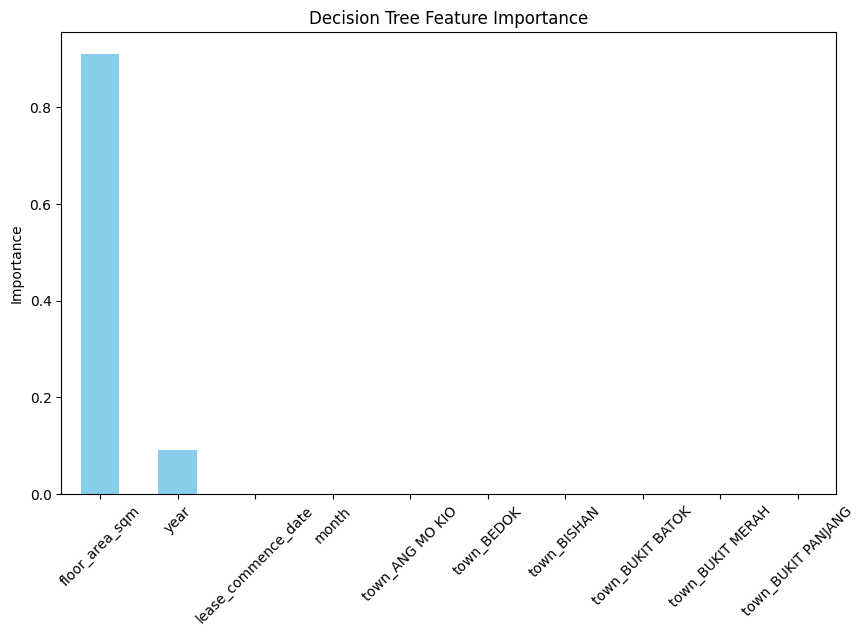

In [60]:
# Feature (independent variable) importance
feat_importance = pd.Series(dtree.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop features driving price changes:")
print(feat_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10,6))
feat_importance.head(10).plot(kind='bar', color='skyblue')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=45)
plt.show()


In [61]:
# Train R² for Decision Tree
train_score_dt = dtree.score(X_train, y_train)
print(f"Decision Tree Train score: {train_score_dt:.6f}")

# Test R² for Decision Tree
test_score_dt = dtree.score(X_test, y_test)
print(f"Decision Tree Test score: {test_score_dt:.6f}")


Decision Tree Train score: 0.750202
Decision Tree Test score: 0.752846


# Model Prediction Task II

## Question:
Explain the factors and considerations in building an in-house predictive model for users. 
You may use the above scenario to support your answer with reasonable assumptions.

## Answer:
First consideration: Whether the model provides value (e.g. save costs, improve KPIs, or reduce manhours).

Second consideration: Whether there is a strategic alignment. If management has set a direction (e.g. develop in-house agentic AI capabilities), 
then building in-house supports long-term ownership and learning.

If either of the considerations above are satisfied, then consider the availability of data.

If the data required is external or highly specialised (e.g. recovery of deleted data from devices, sensor data) then outsourcing may be more practical.

If the data required is internal and accessible, then consider the capability and skills of officers.
Assess whether officers already have the skills required, or whether the skills gap can be closed quickly through training (e.g. learning via learn.gov.sg or a 2-day course). 
If the learning curve is steep and time critical, outsourcing may again be better.

If officers have the capability and skills, then in-house development is possible.